In [0]:
import os
import re
import math
import numpy as np
import pandas as pd
import seaborn as sn
import random 
import csv
from matplotlib import pyplot as plt
%matplotlib inline
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import gensim.downloader as api

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from google.colab import drive
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


In [0]:
#training googlenews model
#model = api.load('word2vec-google-news-300')

filename = 'drive/My Drive/ML Project/GoogleNews-vectors-negative300.bin.gz'
model = KeyedVectors.load_word2vec_format(filename, binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
#testing model
result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
print(result)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('queen', 0.7118192911148071)]


In [0]:
def cleanData (Data):

    string = "!@&*~`<>#$,.?-_/\*%=+|;:(){}1234567890"
    stopwords = np.loadtxt('drive/My Drive/ML Project/stopwords.txt',dtype='str')
    #clean all the tweets one by one
    for i in range(Data.shape[0]):
        
        row = Data.iloc[i,1]
        #print(row)
        row = row.lower()
        #delete all the characters in string
        for char in string:
            row = row.replace(char," ")
        row = row.replace('"'," ")
        row = row.replace('“'," ")
        row = row.replace('”'," ")
        row = row.replace("'"," ")
        #removing all stop words
        headline = row.split()
        resultwords  = [word for word in headline if word.lower() not in stopwords]
        row = ' '.join(resultwords)
        #print(row)
        #print("*******************************************************************")

        #saving cleaned data to headline column
        Data.iloc[i,1] = row

    return Data

In [0]:
df = pd.read_csv('drive/My Drive/ML Project/train.txt',sep='\t')

In [0]:
df= df.astype('str')
Data = pd.DataFrame(data=np.empty((df.shape[0])),columns=['empty'])

In [0]:
Data['labels'] = df.iloc[:,0].str[0]
Data['headlines'] = df.iloc[:,0].str[2:]

In [0]:
Data.head(2)

,empty,labels,headlines
0,0.000000e+00,1,increasingly paranoid campbell's begins stockp...
1,6.917234e-310,1,monster truck escapes


In [0]:
Data = Data.drop('empty',axis=1)

In [0]:
Data.head(5)

,labels,headlines
0,1,increasingly paranoid campbell's begins stockp...
1,1,monster truck escapes
2,0,sunday roundup
3,1,birthday card for david axelrod circling aroun...
4,0,morocco cracks down on journalists


In [0]:
cleanedData = cleanData(Data)
cleanedData.head(5)

,labels,headlines
0,1,increasingly paranoid campbell s begins stockp...
1,1,monster truck escapes
2,0,sunday roundup
3,1,birthday card david axelrod circling around af...
4,0,morocco cracks journalists


In [0]:
#return processed data and indexes of headlines with no word in model
def preprocessing(Data):

  X = pd.DataFrame(data=np.zeros((Data.shape[0],300)))
  mean = 0
  count = 0
  indexes = []

  for x in range(Data.shape[0]):

    headline = Data.iloc[x,1]
    words = headline.split()
    mean =0
    for word in words:
      try:
        value = model[word]
      except:
        value = 0
      mean = mean + value
    try:
      if mean == 0:
        count+=1
        indexes.append(x)
    except:
      pass
    X.iloc[x,:] = mean
  print('No of headlines with no word in model=',count)

  return X, indexes
  

In [0]:
#return processed data and indexes of headlines with no word in model
X, indexes = preprocessing(cleanedData)
print(X.shape)
print(len(indexes))

No of headlines with no word in model= 3
(22891, 300)
3


In [0]:
#removing 3 headlines which are not in our model
print(cleanedData.iloc[indexes[0],1])
print(cleanedData.iloc[indexes[1],1])
print(cleanedData.iloc[indexes[2],1])
cleanedData = cleanedData.drop(cleanedData.index[[indexes[0],indexes[1],indexes[2]]])
print(cleanedData.iloc[indexes[0],1])
print(cleanedData.iloc[indexes[1],1])
print(cleanedData.iloc[indexes[2],1])

yazidi
charlottesville

ncis cease print edition
genetics emphatically deny playing part area man s body
bakery s closing nets man ton free éclairs


In [0]:
#removing 3 headlines vector from X, which are not in our model
print(sum(X.iloc[indexes[0],:]))
print(sum(X.iloc[indexes[1],:]))
print(sum(X.iloc[indexes[2],:]))
X = X.drop(X.index[[indexes[0],indexes[1],indexes[2]]])
print(sum(X.iloc[indexes[0],:]))
print(sum(X.iloc[indexes[1],:]))
print(sum(X.iloc[indexes[2],:]))

0.0
0.0
0.0
9.010892868041992
-2.6740379333496094
-15.83795690536499


In [0]:
Y = cleanedData.loc[:,'labels']
X.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
count,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,...,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000
mean,0.122856,0.357088,0.072446,0.636477,-0.311149,-0.109511,0.155821,-0.581972,0.567538,0.435919,-0.133574,-0.836203,-0.300386,0.188915,-0.600002,0.615708,0.203946,0.753993,0.017391,-0.490923,0.054658,0.288842,0.334831,-0.070660,0.032245,-0.263497,-0.610199,0.485036,0.294516,-0.269918,-0.035350,0.035572,-0.395453,0.039760,-0.078430,-0.145831,0.180589,0.198951,0.260519,0.544887,...,-0.063678,-0.068935,-0.181082,0.113646,0.243695,0.749221,-0.388613,-0.134630,-0.552988,-0.149570,-0.152652,0.565354,0.466637,0.068943,0.368419,-0.432902,-0.378441,-0.492776,-0.353934,0.189681,-0.058272,-0.064525,0.156614,0.543977,0.001317,-0.149083,-0.531896,0.150794,0.338049,0.245669,-0.241971,0.091860,-0.686666,0.101353,-0.261491,-0.274396,-0.017360,-0.356683,0.139033,0.232608
std,0.487115,0.442693,0.459961,0.541030,0.473643,0.495401,0.470596,0.504148,0.499174,0.486110,0.517572,0.546787,0.500039,0.498469,0.493808,0.515624,0.513260,0.526187,0.433966,0.493754,0.515755,0.488490,0.555773,0.455370,0.481191,0.515655,0.505755,0.501790,0.507857,0.482041,0.479211,0.483121,0.518924,0.470799,0.467371,0.465910,0.530124,0.557500,0.445582,0.502454,...,0.471117,0.432135,0.517165,0.493126,0.464259,0.513644,0.492716,0.441712,0.509123,0.453597,0.498622,0.499553,0.527342,0.482813,0.492802,0.455272,0.500202,0.517183,0.463632,0.551997,0.474775,0.459412,0.468373,0.494153,0.465040,0.438334,0.465931,0.491211,0.488803,0.522588,0.526047,0.475597,0.492993,0.478161,0.485280,0.547902,0.492678,0.491100,0.453555,0.513087
min,-2.123779,-1.541992,-3.596924,-2.176758,-5.206953,-8.817993,-2.112274,-9.223162,-1.308960,-2.728210,-2.618530,-11.191120,-3.249184,-1.842773,-6.673248,-1.484131,-2.843727,-1.222290,-1.890198,-7.420864,-2.152588,-2.828125,-2.071167,-2.186432,-2.131836,-5.953808,-13.707230,-1.506836,-1.792404,-3.904793,-5.960716,-2.358887,-2.832764,-5.603096,-4.631073,-8.456284,-2.213104,-2.161804,-1.960693,-1.672363,...,-2.158203,-2.302734,-10.150116,-2.463867,-2.747559,-1.230225,-2.879883,-3.683029,-4.847134,-3.345551,-2.510376,-1.418335,-1.794922,-4.420616,-1.519775,-6.596804,-12.735092,-8.827026,-5.819092,-2.082397,-4.438599,-2.190186,-2.004395,-1.446045,-2.547882,-5.506989,-13.627014,-2.182617,-1.731445,-2.177734,-6.041388,-2.094727,-12.548218,-1.930908,-3.206299,-5.165367,-2.745117,-2.613617,-5.173195,-1.857574
25%,-0.189026,0.062103,-0.215918,0.275459,-0.603424,-0.418701,-0.142700,-0.895752,0.224365,0.115326,-0.465851,-1.174469,-0.611038,-0.138092,-0.906784,0.258301,-0.129395,0.390373,-0.258511,-0.794922,-0.271515,-0.020889,-0.032349,-0.362549,-0.269531,-0.584961,-0.912348,0.155121,-0.042618,-0.566582,-0.338013,-0.266113,-0.722656,-0.259558,-0.369595,-0.425491,-0.158485

In [0]:
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,0.073730,0.819702,0.252075,1.294189,-0.733063,0.781006,-0.676331,-0.635437,1.281738,0.150269,-0.556702,-0.977058,-0.007874,0.946518,-1.371506,0.800049,-0.151611,0.861572,0.397156,-1.469482,-0.215820,0.082031,0.322083,0.247513,1.438721,0.104889,0.517090,-0.237793,-0.266602,0.517532,0.338470,0.480408,-1.259338,-0.444901,-0.639832,0.441223,-0.579590,0.268524,0.743774,0.410889,...,0.060181,0.392822,-0.606445,-0.326782,-0.109619,1.292480,-0.783981,-0.012360,-0.480957,-0.442261,-0.161865,1.127319,1.572723,0.738037,0.720703,-0.647461,-0.390747,0.391357,0.348877,1.662750,0.243042,-0.150391,0.523254,-0.109436,0.027939,0.186218,-0.837662,0.178467,0.909271,0.561279,-0.433594,-0.712891,-0.706543,0.972290,-0.225098,-1.926758,-0.140869,0.036255,0.759980,0.978638
1,0.316406,0.380737,-0.422073,0.101318,0.222900,-0.194336,-0.197998,-0.382568,0.574707,0.073730,0.060303,-0.641602,0.151855,-0.441162,-0.246338,0.011719,-0.295532,0.295654,0.266113,-0.303589,0.242188,0.208008,-0.020020,0.389648,0.584961,-0.567139,-0.004883,0.304810,0.610352,-0.301270,0.071533,-0.268066,-0.120117,0.559570,-0.498230,-0.041504,0.550537,0.183685,-0.103760,0.163086,...,-0.086243,-0.163574,-0.315186,0.344177,0.314941,0.227051,-0.502930,0.473495,-0.388672,0.456543,-0.318909,-0.166016,0.284180,0.010498,0.037842,-0.016968,-0.122681,-0.159180,0.197632,0.217285,-0.187744,-0.140747,0.043015,-0.188232,0.095459,-0.134232,-0.264648,-0.118179,-0.028687,0.057617,-0.585938,-0.046143,-0.410400,0.281738,-0.588379,-0.169434,-0.367065,-0.240234,-0.251373,-0.262695
2,-0.216309,0.288651,-0.267090,0.143982,0.218750,-0.507080,-0.018311,-0.373047,0.081299,0.385742,-0.666992,-0.340820,-0.394043,-0.013672,-0.078369,0.005859,-0.370361,0.162354,0.549805,-0.647461,0.438477,0.190796,0.055664,-0.016113,-0.222656,0.096191,0.222656,0.419434,-0.158447,0.005127,0.110596,0.081787,0.325684,-0.326172,0.084473,0.398438,-0.294922,-0.199585,0.560547,0.463379,...,0.208130,-0.013672,0.369629,0.052246,-0.022949,0.243652,-0.085938,0.139404,-0.125488,0.484863,-0.309082,0.190918,0.238770,0.326660,0.340820,-0.398926,0.064331,-0.344727,-0.112183,0.683594,-0.034668,0.018646,0.088989,0.720703,-0.108032,-0.514648,-0.312622,0.557617,-0.038086,-0.035156,0.653320,-0.248779,0.076172,0.479980,-0.031128,0.017578,-0.414307,-0.164062,-0.317383,0.365112
3,-0.564453,0.799683,-0.086670,1.522217,-0.766113,-0.355713,0.226318,-1.685791,0.572998,0.652588,0.109283,-1.041992,-0.635254,0.028015,-0.418213,-0.066315,-0.526123,0.835938,-0.039429,-1.208008,0.384216,0.934723,0.574463,-0.406128,-0.095947,0.386963,-1.354614,0.509766,0.696777,-0.920105,-0.001953,-0.420389,-0.094330,-0.745209,-0.384033,-0.104614,0.594635,-0.106934,-0.009399,0.062775,...,-0.821411,-0.194077,-0.160828,-1.133301,-0.794678,0.538818,-0.021118,0.099426,-0.757812,0.235046,0.105062,0.115723,0.385010,0.176025,1.259766,-0.680542,-0.264282,-0.568237,-1.536865,0.689087,-0.199463,-0.154068,-0.454834,0.665955,-0.249146,0.335571,-0.607300,0.548279,0.766980,0.477554,-0.721863,0.067627,-0.603027,0.523926,0.160767,-1.221191,-0.605042,0.078766,-0.946289,0.568359
4,-0.149399,0.291626,-0.256714,0.146240,-0.306000,-0.014526,-0.152313,-0.293701,0.109009,0.254883,-0.227051,-0.125671,0.036865,0.187012,-0.536133,-0.082581,0.090332,0.226562,-0.421875,-0.052948,0.590088,-0.078613,0.124512,-0.386963,0.593750,-0.455261,0.219360,0.375000,0.173828,-0.548279,-0.677734,-0.073975,-0.174805,0.323242,0.000488,-0.111572,-0.056519,0.644531,0.023193,0.230804,...,-0.130249,-0.027832,0.267975,-0.099609,-0.189209,0.381836,-0.186279,-0.221436,-0.261963,-0.155151,-0.139984,0.506836,0.316589,0.071970,0.393066,0.046875,0.441772,-0.383530,-0.238770,0.376465,-0.231934,-0.442631,0.384766,0.206543,0.304443,-0.811523,-0.498047,0.506836,-0.092

In [0]:
X = X.to_numpy()
Y = Y.to_numpy()
Y = Y.astype(int)
Y.dtype

dtype('int64')

In [0]:
print(Y[0:10])

[1 1 0 1 0 0 1 1 0 1]


In [0]:
#np.savetxt('drive/My Drive/ML Project/XData',X,delimiter=',')
#np.savetxt('drive/My Drive/ML Project/YData',Y,delimiter=',')
m = np.mean(X,axis=0)
m.shape
std = np.std(X,axis=0)
std.shape

(300,)

In [0]:
def normalize(X):
 
  m = np.mean(X,axis=0)
  std = np.std(X,axis=0)

  for x in range(X.shape[1]):

    X[:,x] = X[:,x] - m[x]
    X[:,x] = X[:,x] / std[x]

  
  return X

In [0]:
X = normalize(X)
#X = pd.DataFrame(data=X)
#X.describe()

In [0]:
#X = X.to_numpy()

In [0]:
def predict(X, thetas):
    '''
    Calculates the hypothesis for any input sample `X` given the parameters `thetas`.
    
    Arguments
    ---------
    X : float array
        The input sample.
    
    thetas : float array
        The parameters for the regression function.
    
    Returns
    -------
    h_x : float array
        The hypothesis for input sample.
    '''
    #pridicts class using z = w· x+b 
    h_x = np.dot(X,thetas[0:np.size(X,axis=1)])
    h_x = h_x + thetas[np.size(X,axis=1)]

    return h_x

In [0]:
def sigmoid(H_x):

#this function return sigmoid value of input using σ(z) = 1/1+e^(−z)    
 
    
    for i in range(np.size(H_x,axis=0)):

        if H_x[i] >= 0:
            z = math.exp(-H_x[i])
            H_x[i] = 1 / (1 + z)
        else:
            z = math.exp(H_x[i])
            H_x[i] = z / (1 + z)
    
    H_x = np.minimum(H_x, 0.9999999)  # Set upper bound
    H_x = np.maximum(H_x, 0.0000001)  # Set lower bound

    return H_x

In [0]:
thetas = np.zeros((np.size(X,axis=1)+1,1))
h = predict(X,thetas)
print(h.shape)
h = sigmoid(h)
nan = np.isnan(h)
for x in range(np.size(nan,0)):
  if nan[x] == True:
    print(x)
    print('true')

(22888, 1)


In [0]:
def crossentropyloss(X, Y, thetas,lambdda):
    
    '''
    Computes cost for linear regression. Computes the cost of using `theta` as the
    parameter for linear regression to fit the data points in `X` and `Y`.
    
    Arguments
    ---------
    X : array
        The input dataset of shape (m, ), where m is the number of training examples.
    
    Y : array
        The values of the function at each data point. This is a vector of
        shape (m, ), where m is the number of training examples.
    
    thetas : array
        The parameters for the regression function.

    
    Returns
    -------
    J : float
        The value of the cross-entrpy loss function.
    
    '''
    #calculates cross-entrpy loss using 
    #LCE(w,b) = −[y logσ(w· x+b) + (1−y)log(1−σ(w· x+b))] 

    H_x = predict(X,thetas) 
    sig = sigmoid(H_x)
 
    log_left = np.log10(sig)
    right_sig = 1-sig
    #print(right_sig)
    log_right = np.log10(right_sig)
    
    #print(log_left)
    #print(log_right)

    #log_left = log_left.filled(0)
    #log_right = log_right.filled(0)

    left = np.dot(log_left.T,Y)

    Y_1 = 1-Y
    right = np.dot(log_right.T,Y_1)
    #print(right)

    J = sum(left) + sum(right)
    #regularization l1
    R = np.sum(np.abs(thetas))
    #regularization l2
    #R = np.sum(np.square(thetas))
    #print(J)
    J = J
    J = J/np.size(X,axis=1)
    J = J*-1
    J = J + (lambdda*R/(np.size(X,axis=1)))
    print(J)

    return J

In [0]:
thetas = np.zeros((np.size(X,axis=1)+1,1))
loss= crossentropyloss(X, Y, thetas_batch,0.1)

22.540218329206606


In [0]:
def minibatchgradientDescent(X, Y, alpha, n_epoch, thetas, m,lambdda):
    """
    Performs gradient descent to learn `theta`. Updates `theta` by taking `n_epoch`
    gradient steps with learning rate `alpha`.
    
    Arguments
    ---------
    X : array
        The input dataset of shape (m, ), where m is the number of training examples.
    
    Y : array
        The values of the function at each data point. This is a vector of
        shape (m, ), where m is the number of training examples.
    
    alpha : float
        The learning rate.
    
    n_epoch : int
        The number of iterations for gradient descent. 
    
    Returns
    -------
    thetas : float array
        The parameter for the regression function.
        
    
    J : list
        A python list for the values of the cost function after each iteration.
    
 
    Computes following equation.

    θt+1 = θt −η∇L(f(x;θ), y) where η = learning rate and ∇L = stepsize 
    g = [σ(w· x+b)−y]xj
    θj ←θj − η g

    While debugging, it can be useful to print out the values of 
    the cost function (computeCost) here.
    """
    # initialize some useful values
    features = np.size(X,1) #number of features
    
    J = list()  # list to store cost
    thetas_list = list()  # list to store thetas
    
    thetas = np.zeros((np.size(X,axis=1)+1,1))
    loss = crossentropyloss(X, Y, thetas,lambdda)


    for epoch in range (n_epoch):
        
        #print(thetas)
        #to choose random samples from data
        a = random.choice(range((np.size(X,axis=0)-m))) 
        h_x = predict(X[a:a+m,:], thetas)
        h_x = sigmoid(h_x)
        diff = np.subtract(h_x, Y)
        #print("Difference",((np.sum(diff)/m)))
        print(epoch)
     
        #updating values of all the weights in thetas array
        for x in range (np.size(X,1)):
            
            g = np.dot(X[a:a+m,x],diff)
            Sum = np.sum(g)/m
            #L2 regularization
            #R2 =  ((lambdda*np.sum(thetas[x]))/m)
            #Sum = Sum  + R2
            #L1 regularization
            #if(thetas[x]>0):
             # Sum = Sum + (lambdda/m)
            #else:
             # Sum = Sum - (lambdda/m)

            thetas[x] = thetas[x] - alpha*(Sum)

        #updating value of bias in thetas array
        Sum = np.sum(diff)
        thetas[np.size(X,axis=1)] = thetas[np.size(X,axis=1)] - alpha*(Sum/m)
            
        
        ### END CODE HERE ###

        loss = crossentropyloss(X, Y, thetas,lambdda)
        J.append(loss)
        #print(loss)
        
    return thetas, J

In [0]:
n_epoch =300
alpha = 0.1
lambdda = 0.001
m = 32

thetas_batch = np.zeros((np.size(X,axis=1)+1,1))
thetas_batch, Jb = minibatchgradientDescent(X, Y, alpha, n_epoch, thetas_batch, m,lambdda)


22.966581802524004
0
240.21819139741726
1
280.063210114874
2
232.1186678304037
3
279.1272910328772
4
272.04234912511134
5
297.0504766157979
6
255.28708086614355
7
283.1333036696735
8
241.13711087124628
9
240.31785371710353
10
245.7545111240383
11
226.8543869722369
12
274.28592113423906
13
221.863908216603
14
277.2575036461372
15
228.88483089488676
16
245.62837011156975
17
264.3585689561316
18
251.87627124910043
19
317.57246307251665


Confusion Matrix:
 [[1850, 1152], [1146, 1575]]
Accuracy =  0.5984623449239909
Precision =  0.6162558294470353
Recall =  0.6174899866488651
F1 score =  0.6168722907635877


0

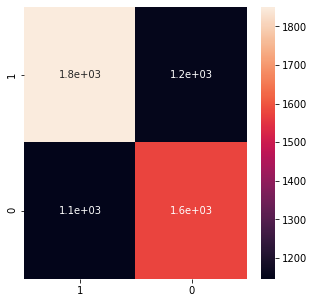

In [0]:
my_Y = finalpredict(X_test,thetas_batch) #predict test data on base of thetas value provided
confusionMatrix(my_Y, Y_test)

In [0]:
plt.subplots(1, 1,figsize=(18,8))
plt.plot(range(np.size(Jb,axis=0)),Jb)
plt.xlabel('Epochs')
plt.ylabel('Batch Cost')

In [0]:
#predict test data on base of thetas value provided
def finalpredict(X, thetas):
    '''
    Calculates the hypothesis for any input sample `X` given the parameters `thetas`.
    
    Arguments
    ---------
    X : float array
        The input sample.
    
    thetas : float array
        The parameters for the regression function.
    
    Returns
    -------
    h_x : float array
        The hypothesis for input sample.
    '''
    #pridicts class using z = w· x+b 
    h_x = np.dot(X,thetas[0:np.size(X,axis=1)])
    h_x = h_x + thetas[np.size(X,axis=1)]
    h_x = sigmoid(h_x)

    #threshold for 1 and 0 prediction 
    for i in range(np.size(h_x)):
        if (h_x[i] > 0.5):
            h_x[i] = 1
        else:
            h_x[i] = 0
    

    return h_x

In [0]:
#creates confusion matrix from actual and predicted tags and value of precision, recall etc
def confusionMatrix (my_Y, Y):

    TP = 0
    TN = 0
    FP = 0
    FN = 0

    for i in range(np.size(my_Y)):

        if(Y[i] == 1):
            if(my_Y[i] == 1):
                FP +=1

        if(Y[i] == 1):
            if(my_Y[i] == 0):
                TN+=1

        if(Y[i] == 0):
            if(my_Y[i] == 0):
                FN+=1

        if(Y[i] == 0):
            if(my_Y[i] == 1):
                TP+=1

    ConfMatrix = [[TP,FP],
                  [FN,TN]]
    print('Confusion Matrix:\n',ConfMatrix)

    Accuracy = (TP+TN)/(TP+TN+FN+FP)
    Precision = TP/(TP+FP)
    Recall = TP/(TP+FN)
    F1 = (2*(Precision*Recall))/(Precision+Recall)

    df_cm = pd.DataFrame(ConfMatrix, index = [i for i in "10"],
                  columns = [i for i in "10"])
    plt.figure(figsize = (5,5))
    sn.heatmap(df_cm, annot=True)
    
    
    print('Accuracy = ', Accuracy)
    print('Precision = ', Precision)
    print('Recall = ', Recall)
    print('F1 score = ', F1)

    return 0

In [0]:
df = pd.read_csv('drive/My Drive/ML Project/test.txt',sep='\t')

In [0]:
df= df.astype('str')
Data = pd.DataFrame(data=np.empty((df.shape[0])),columns=['empty'])

In [0]:
Data['labels'] = df.iloc[:,0].str[0]
Data['headlines'] = df.iloc[:,0].str[2:]

In [0]:
Data.head(2)

,empty,labels,headlines
0,0.000000e+00,0,"an open letter to editors rejecting #metoo, #m..."
1,6.917178e-310,1,group of christie campaign deserters found in ...


In [0]:
Data = Data.drop('empty',axis=1)

In [0]:
Data.head(5)

,labels,headlines
0,0,"an open letter to editors rejecting #metoo, #m..."
1,1,group of christie campaign deserters found in ...
2,0,noose found in african-american history museum...
3,1,democratic congressman protests trump's enviro...
4,0,rex tillerson calls reports of his ouster 'lau...


In [0]:
testData = cleanData(Data)

In [0]:
testData.head(5)

,labels,headlines
0,0,open letter editors rejecting metoo meat submi...
1,1,group christie campaign deserters found forest
2,0,noose found african american history museum ex...
3,1,democratic congressman protests trump s enviro...
4,0,rex tillerson calls reports ouster laughable


In [0]:
#processed data and return indexes of headlines with no word in model
X_test, indexes = preprocessing(testData)
print(X_test.shape)
print(len(indexes))

No of headlines with no word in model= 0
(5723, 300)
0


In [0]:
Y_test = testData.loc[:,'labels']
X_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,-1.112793,0.780029,0.455811,0.773682,0.039185,0.215210,0.074402,0.212738,0.817383,0.838867,-0.032227,-0.616882,-0.118103,0.157471,-0.435974,-0.208618,0.300903,-0.005371,-0.118973,-0.436371,1.641113,0.687256,-0.181030,-0.256836,0.750366,-0.671387,-0.129272,0.160278,0.532288,-0.926361,-0.078491,-0.885498,-0.621826,0.164429,0.332764,0.255859,0.661987,0.961792,-0.218018,0.769287,...,0.018028,-0.211670,-0.535278,-0.482239,0.120361,0.224365,-0.651489,0.420685,-0.646729,-0.746338,0.302979,1.027100,0.483215,-0.176514,0.428345,-0.668945,-0.528748,-0.209900,0.266418,1.190430,-0.124023,-0.069092,-0.208344,0.412598,0.354492,0.668030,0.125977,1.134766,0.370728,0.572144,-0.314667,-0.791748,-0.379883,1.155762,0.494080,0.300537,0.562561,-0.772583,-0.414795,0.691650
1,0.704102,0.338440,-0.088043,0.130981,0.600811,-0.598633,-0.385010,-0.323828,0.222122,-0.048828,0.437500,-0.752441,-0.763672,0.200562,-0.635498,0.007690,0.316284,0.204834,-0.895203,0.090317,0.293335,-0.046265,-0.405273,-0.188354,-0.280029,-1.048950,-0.690002,0.282471,0.400558,-0.228981,0.452637,-0.053329,-0.500977,-0.116272,-0.317017,-0.705933,-0.006088,-0.331055,0.645020,-0.031677,...,0.206177,-0.295654,0.515854,0.492676,-0.035034,-0.212646,-1.162292,-0.244873,-0.569824,-0.025391,0.618042,0.238770,0.489990,-0.134521,0.133118,-0.053223,0.061035,-0.335180,0.073486,0.233276,-0.036133,-0.684326,0.433838,0.152161,-0.083130,-0.684692,-0.920166,0.236450,0.718506,0.424561,-0.377930,-0.047363,-0.583496,-0.127228,-0.168091,-0.421387,0.439209,-0.144379,0.791382,0.365540
2,-0.220215,1.229004,0.310913,1.768066,-0.280273,-0.634094,0.148682,-0.867163,0.567627,-0.423828,0.231720,-1.950684,-1.410400,0.058472,-0.809570,0.268921,-0.577515,1.371338,-0.315674,-0.523438,0.056030,-0.620117,0.173988,-1.152908,-0.953384,0.159851,-2.281982,0.570312,0.327866,-0.204079,0.267822,0.098480,-1.051025,-0.138062,-0.007385,0.194824,-0.482895,0.886230,0.475708,0.537613,...,-0.230957,0.182745,0.146484,0.280396,0.056885,1.218689,0.715347,-0.534851,-1.497498,-0.647705,-0.343719,0.656250,0.109009,0.257385,1.064758,-0.669250,-1.190918,-0.305420,-0.795410,0.575439,0.806274,1.077515,-0.174744,0.546387,-1.460144,0.169556,-0.326172,0.687378,0.866943,-0.736816,-0.870361,0.158844,-0.388428,1.505493,-0.430908,-0.593018,-0.137207,-0.065277,-0.132751,-0.126831
3,-0.460495,0.960876,0.474609,1.914612,-0.471741,-1.516251,-0.466263,-0.202026,1.495361,0.725769,-0.024559,-1.408997,-0.213440,0.124939,-1.322021,0.587769,0.429932,1.172485,-0.380981,-1.040771,0.501831,0.220215,0.456909,0.303772,-0.681274,0.091736,-1.321869,-0.466980,1.772461,-0.426208,0.851898,-0.291260,-2.051270,1.538696,0.679382,-0.830322,1.382278,1.021851,0.757233,1.598877,...,-0.624252,-0.104004,0.681213,1.674805,1.634033,1.262512,-1.766602,-0.261185,-1.568848,-0.537323,-0.358978,0.681274,-0.558777,0.260132,-0.604980,-1.306702,-0.208801,-1.509399,-1.819580,0.596619,-0.349731,0.139893,1.188721,1.613647,-0.378708,-0.753395,-1.018738,-0.440735,1.644531,-0.495605,-0.433350,-1.399902,-1.244823,0.199219,1.128784,-0.080750,0.847412,-0.405518,1.558411,2.097168
4,-0.460938,0.085632,-0.272705,-0.189941,-0.072021,-0.117081,0.158081,-0.726074,0.934082,0.249512,-0.253174,-0.492432,-0.233398,0.087036,0.198486,1.014038,0.193872,-0.141113,-0.408813,-0.433533,0.558655,-0.030396,0.416504,-0.301270,-0.409180,-0.273331,-0.986816,0.327393,0.171692,-0.057373,-0.205566,-0.067749,-0.613403,-0.364258,0.126801,0.491699,0.032532,0.872070,0.343109,0.912842,...,0.387939,0.747559,0.082764,1.142822,0.121094,0.526062,-0.579102,-0.485596,-0.325287,-0.320190,-0.317139,0.629883,0.609955,-0.645020,0.107910,-0.156754,-0.174988,0.126953,0.034668,0.833697,-0.240234,-0.219727,-0.056152,0.136017,0.194824,-0.472412,-0.363770,0.062317,0.0

In [0]:
X_test = X_test.to_numpy()
Y_test = Y_test.to_numpy()
Y_test = Y_test.astype(float)
Y_test.dtype

dtype('float64')

In [0]:
#np.savetxt('drive/My Drive/ML Project/X_testData.txt',X_test,delimiter=',')
#np.savetxt('drive/My Drive/ML Project/Y_testData.txt',Y_test,delimiter=',')

In [0]:
X_test = normalize(X_test)

Confusion Matrix:
 [[1850, 1152], [1146, 1575]]
Accuracy =  0.5984623449239909
Precision =  0.6162558294470353
Recall =  0.6174899866488651
F1 score =  0.6168722907635877


0

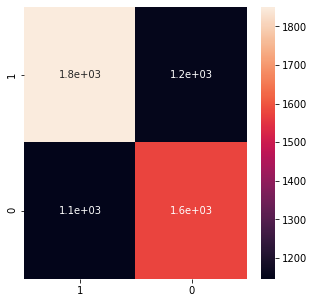

In [0]:
my_Y = finalpredict(X_test,thetas_batch) #predict test data on base of thetas value provided
confusionMatrix(my_Y, Y_test)
#Result after small number of epochs

Confusion Matrix:
 [[1215, 1211], [1781, 1516]]
Accuracy =  0.4771972741569107
Precision =  0.5008244023083265
Recall =  0.4055407209612817
F1 score =  0.4481741054961269


0

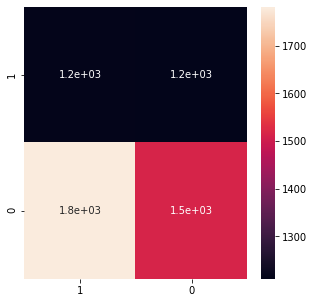

In [0]:
my_Y = finalpredict(X_test,thetas_batch) #predict test data on base of thetas value provided
confusionMatrix(my_Y, Y_test)
#Result after large no of epochs